# IT Diving | Machine Learning

In [1]:
# Импортируем необходимые библиотеки

from os.path import exists

import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from PIL import Image
from sklearn.cluster import KMeans, SpectralClustering

%matplotlib inline

In [2]:
# Зафиксируем сид для генератора случайных чисел
# Это полезно для воспроизводимости результатов

RANDOM_SEED = 0xC0FFEE

# Классификация

Воспользуемся выборкой данных о пациентах с доброкачественными и злокачественными опухолями. Наша задача — научиться их отличать.

Подробнее про датасет можно прочитать вот [тут](
https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data).

In [6]:
def read_cancer_dataset(path_to_csv: str, shuffle: bool = True) -> pd.DataFrame:
    """Функция для чтения данных с диска, а также их случайного перемешивания

    Parameters
    ----------
    path_to_csv: Путь к файлу cancer.csv
    shuffle: Если True, то перемешивает данные

    Return
    ------
    dataframe: Данные в формате DataFrame
    """
    dataset = pd.read_csv(path_to_csv)
    if shuffle:
        dataset = dataset.sample(frac=1)
    return dataset

In [8]:
# Колонка "label" отвечает за тип опухоли
# Колонки 1-30 отвечают за признаки

cancer_dataset = read_cancer_dataset("cancer.csv", shuffle=True)
cancer_dataset.head()

,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
74,B,12.310,16.52,79.19,470.9,0.09172,0.06829,0.03372,0.02272,0.1720,...,14.11,23.21,89.71,611.1,0.1176,0.1843,0.17030,0.08660,0.2618,0.07609
362,B,12.760,18.84,81.87,496.6,0.09676,0.07952,0.02688,0.01781,0.1759,...,13.75,25.99,87.82,579.7,0.1298,0.1839,0.12550,0.08312,0.2744,0.07238
33,M,19.270,26.47,127.90,1162.0,0.09401,0.17190,0.16570,0.07593,0.1853,...,24.15,30.90,161.40,1813.0,0.1509,0.6590,0.60910,0.17850,0.3672,0.11230
273,B,9.742,15.67,61.50,289.9,0.09037,0.04689,0.01103,0.01407,0.2081,...,10.75,20.88,68.09,355.2,0.1467,0.0937,0.04043,0.05159,0.2841,0.08175
189,B,12.300,15.90,78.83,463.7,0.08080,0.07253,0.03844,0.01654,0.1667,...,13.35,19.59,86.65,546.7,0.1096,0.1650,0.14230,0.04815,0.2482,0.06306


Необходимо подготовить данные к работе, а именно: разбить на тренировочную и тестовую части.

<u>Тренировочная часть</u> используется для обучения моделей, именно по ней ищутся необходимые зависимости в данных.

<u>Тестовая часть</u> используется для оценки качества моделей. Это данные, которые модель не видела, поэтому качество предсказаний по ним позволит оценить ее обобщающие способности.

Крайне важно, чтобы тестовая и тренировочная части описывали одинаковую природу данных. Например, в случае задачи классификации, важно чтобы соотношение классов было приблизительно равно в них. Иначе мы можем неправильно интерпретировать результаты.

In [5]:
def prepare_cancer_dataset(
    dataset: pd.DataFrame, label_col_name: str = "label", test_size: float = 0.1
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Функция для выделения таргета и признаков,
    а также разделения на тренировочную и тестовую части.

    Для таргета необходимо привести данные к формату 0/1.
    Сопоставим 0 доброкачественной опухоли ("B"),
    а 1 злокачественной ("M")

    Parameters
    ----------
    dataset: DataFrame с датасетом
    label_col_name: Название колонки с таргетом
    test_size: доля тестовой выборки относительно всего датасета

    Return
    ------
        4 numpy массива: X_train, X_test, y_train, y_test
        X_train, X_test -- матрицы признаков размером [n_elements; 30]
        y_train, y_test -- массивы из 0 и 1 размером [n elements]
    """
    
    dataset[label_col_name] = dataset[label_col_name].apply(lambda x: int(x == "M"))
    
    X = dataset.drop(columns=[label_col_name])
    y = dataset[label_col_name]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    
    return X_train, X_test, y_train, y_test

In [6]:
# Выполним подготовку данных
X_train, X_test, y_train, y_test = prepare_cancer_dataset(cancer_dataset)

# Код ниже проверяет правильность подготовки данных
# Если он упал, то надо исправить функцию выше
assert X_train.shape == (512, 30) and y_train.shape == (512,)
assert X_test.shape == (57, 30) and y_test.shape == (57,)

train_ratio = y_train.sum() / len(y_train)
test_ratio = y_test.sum() / len(y_test)
assert train_ratio < 0.5
assert np.abs((test_ratio - train_ratio) / train_ratio) < 0.015

Начнем с наивного решения — модель, которая предсказывает наиболее популярный класс.
Реализуйте методы `fit` и `predict` у класса ниже.

In [7]:
class MostCommonClassifier:
    def __init__(self):
        self.predict_class = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Функция обучения наивной модели.
        Она получает на вход X и y,
        чтобы иметь схожий интерфейс с другими моделями.

        Функция определяет самый популярный класс и
        сохраняет его в predict_class

        Parameters
        ----------
        X: признаки, не используются
        y: таргет, номера классов, одномерный массив
        """
        self.predict_class = int(np.sum(y) >= len(y) / 2)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Функция для предсказания классов

        Parameters
        ----------
        X: элементы, для которых надо предсказать класс
            матрица размером [n_elements; n_features]

        Return
        ------
            предсказанный класс для каждого элемента
            numpy массив размером [n_elements]
        """
        if self.predict_class is None:
            raise RuntimeError("Call fit before predict")
        n_elements = X.shape[0]
        predictions = np.full(n_elements, self.predict_class)
        return predictions

"Обучим" наивную модель и оценим ее качество.

Для оценки качества воспользуемся двумя метриками:
1. Точность (accuracy) измеряет, как часто модель предсказывает правильные ответы из всех возможных ответов. Она вычисляется как отношение числа правильных предсказаний к общему числу предсказаний. Например, если модель правильно предсказала 80 из 100 объектов, то точность будет равна 0.8 или 80%.

2. F1-score — более сложная метрика, она измеряет сбалансированность модели, учитывая как точность (precision), так и полноту (recall) предсказаний. Точнее говоря, она считает их гармоническое среднее. Использование такой метрики позволяет более точно оценить модели в случае сильной несбалансированности в данных.

In [8]:
def print_classification_report(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%", f"F1-score: {f1 * 100:.2f}%", sep="\n")

In [9]:
model_most_common = MostCommonClassifier()
model_most_common.fit(X_train, y_train)
y_pred_most_common = model_most_common.predict(X_test)

print_classification_report(y_test, y_pred_most_common)

Accuracy: 63.16%
F1-score: 0.00%


Воспользуемся алгоритмом "K ближайших соседей" для решения нашей задачи.

In [10]:
model_v1 = KNeighborsClassifier(n_jobs=-1)
model_v1.fit(X_train, y_train)
y_pred_v1 = model_v1.predict(X_test)

print_classification_report(y_test, y_pred_v1)

Accuracy: 91.23%
F1-score: 87.18%


In [13]:
model_v2 = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
model_v2.fit(X_train, y_train)
y_pred_v2 = model_v2.predict(X_test)

print_classification_report(y_test, y_pred_v2)

Accuracy: 92.98%
F1-score: 89.47%


Одна из особенностей алгоритма "K ближайших соседей" — это необходимость вычислять расстояние между векторами признаков. По умолчанию используется обычное евклидово расстояние:

$$
\text{dist}(p, q) = \sqrt{\sum_{i=1}^n (p_i^2 - q_i^2)}
$$

Здесь $p$ и $q$ — это вектора размерности $n$, то есть массивы, описывающие $n$ признаков.

Из формулы можно заменить, что если значения одного из признаков очень большие, то он будет подавлять вклад признаков с маленькими значениями.

Посмотрим на средние значения каждого признака в нашем датасете.

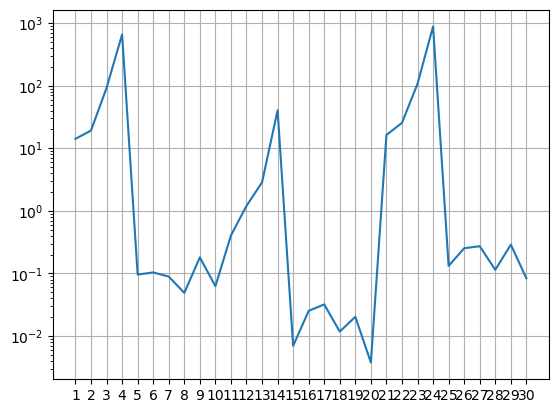

In [14]:
pyplot.grid(visible=True)
pyplot.yscale("log")
pyplot.plot(X_train.mean(axis=0))
pyplot.show()

Можно заметить, что некоторые признаки в среднем варьируются возле 1000, тогда как другие меньше 0.01.

Можно отмасштабировать признаки, а именно привести каждый признак к среднему 0 и дисперсии 1.

In [15]:
def scale_features(
    train_data: np.ndarray, test_data: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Функция для масштабирования данных
    Переводит каждый столбец данных в новый со средним 0 и дисперсией 1.

    Для подсчета статистики и обучения используется тренировочная часть.
    Затем масштабирование применяется и к тестовым данным.

    Parameters
        ----------
        train_data: матрица размером [train_size; n_features]
            Тренировочная часть
        test_data: матрица размером [test_size; n_features]
            Тестовая часть

        Return
        ------
            train_data_scaled, test_data_scaled
                numpy матрицы с отмасштабированными данными
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit(train_data, test_data).transform(train_data)
    X_test_scaled = scaler.transform(test_data)
    return X_train_scaled, X_test_scaled

In [16]:
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

mean, std = X_train_scaled.mean(axis=0), X_train_scaled.std(axis=0)
assert np.allclose(mean, 0) and np.allclose(std, 1)

Обучим `KNeighborsClassifier` на новых данных иподобрём оптимальные гиперпараметры.

In [17]:
model_v3 = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
model_v3.fit(X_train_scaled, y_train)
y_pred_v3 = model_v3.predict(X_test_scaled)

print_classification_report(y_test, y_pred_v3)

Accuracy: 98.25%
F1-score: 97.56%


# Регрессия

Датасет [Boston](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) - набор данных с информаций о медианной стоимости домов, а также различных характеристик района.
Ознакомиться с датасетом можно по ссылке выше, а ниже представленно описание каждого столбца в данных:
```
1. crim      per capita crime rate by town
2. zn        proportion of residential land zoned for lots over 25,000 sq.ft.
3. indus     proportion of non-retail business acres per town
4. chas      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. nox       nitric oxides concentration (parts per 10 million)
6. rm        average number of rooms per dwelling
7. age       proportion of owner-occupied units built prior to 1940
8. dis       weighted distances to five Boston employment centres
9. rad       index of accessibility to radial highways
10. tax      full-value property-tax rate per \$10,000
11. ptratio  pupil-teacher ratio by town
12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. lstat    % lower status of the population
14. medv     median value of owner-occupied homes in \$'s
```

Наша задача — научится предсказывать стоимость дома по критериям района. То есть вместо ограниченного числа значений, модель теперь должна предсказывать любые целые числа.

Начнем с функции `read_boston_dataset`, которая считывает датасет с диска. В данных первые 14 строчек не относятся к данным, а описывают колонки.

In [18]:
def read_boston_dataset(path_to_csv: str, shuffle: bool = True) -> np.ndarray:
    """Функция для чтения данных с диска, а также их случайного перемешивания

    Parameters
    ----------
    path_to_csv: Путь к файлу boston.csv
    shuffle: Если True, то перемешивает данные

    Return
    ------
    dataframe: Данные в формате DataFrame
    """
    boston = pd.read_csv(path_to_csv, skiprows=14)
    if shuffle:
        boston = boston.sample(frac=1)
    return boston

In [19]:
boston_dataset = read_boston_dataset("boston.csv")
boston_dataset.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
81,0.04462,25.0,4.86,0,0.426,6.619,70.4,5.4007,4,281.0,19.0,395.63,7.22,23900.0
194,0.01439,60.0,2.93,0,0.401,6.604,18.8,6.2196,1,265.0,15.6,376.70,4.38,29100.0
70,0.08826,0.0,10.81,0,0.413,6.417,6.6,5.2873,4,305.0,19.2,383.73,6.72,24200.0
208,0.13587,0.0,10.59,1,0.489,6.064,59.1,4.2392,4,277.0,18.6,381.32,14.66,24400.0
368,4.89822,0.0,18.10,0,0.631,4.970,100.0,1.3325,24,666.0,20.2,375.52,3.26,50000.0


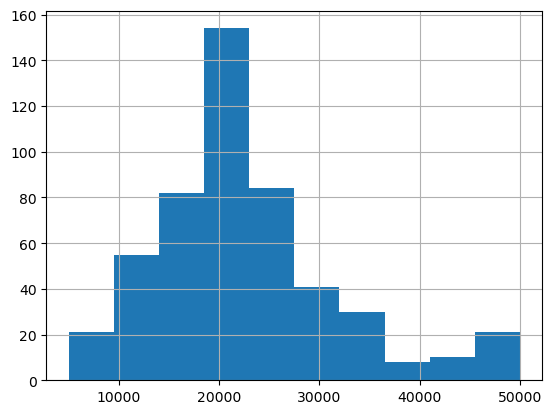

In [20]:
# Посмотрим на данные чуть ближе
# Оценим распределение цен в датасете

pyplot.hist(boston_dataset["medv"])
pyplot.grid(visible=True)
pyplot.show()

1. Наибольшее количество домов стоит около 20 000 \\$.
2. Среди дорогих домов стоимостью выше 40 000 \\$ большая часть домов стоит от 45 000 \\$ до 50 000 \\$.
3. График количества домов до 40 000 \\$ расположен симметрично относительно своей максимальной точки при 20 000 \\$ и близок к графику нормального распределения.

По аналогии с задачей классификацией, необходимо выделить тренировочную и тестовую выборку.

In [21]:
def prepare_boston_dataset(
    dataset: pd.DataFrame, label_col_name: str = "medv", test_size: float = 0.1
) -> tuple[np.ndarray, ...]:
    """Функция для выделения таргета и признаков,
    а также разделения на тренировочную и тестовую части.

    Parameters
    ----------
    dataset: DataFrame с датасетом
    label_col_name: Название колонки с таргетом
    test_size: доля тестовой выборки относительно всего датасета

    Return
    ------
        4 numpy массива: X_train, X_test, y_train, y_test
        X_train, X_test -- матрицы признаков размером [n_elements; 13]
        y_train, y_test -- массивы с ценами размером [n elements]
    """ 
    X = dataset.drop(columns=[label_col_name])
    y = dataset[label_col_name]

    # масштабирование данных
    scaler = StandardScaler() 
    scaler.fit(X) 
    X_scaled = scaler.transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_test = scale_features(X_train, X_test)
    
    return X_train, X_test, y_train, y_test


In [22]:
X_train, X_test, y_train, y_test = prepare_boston_dataset(boston_dataset)

# Код ниже проверяет правильность подготовки данных
# Если он упал, то надо исправить функцию выше

assert X_train.shape == (455, 13) and y_train.shape == (455,)
assert X_test.shape == (51, 13) and y_test.shape == (51,)

Аналогично задаче классификации, начнем с наивного решения. Для задаче регрессии можно использовать, например, среднее значение по датасету.

In [23]:
class MeanRegression:
    def __init__(self):
        self.mean_value = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Функция обучения наивной модели.
        Она получает на вход X и y,
        чтобы иметь схожий интерфейс с другими моделями.

        Функция определяет среднюю величину таргета
        и сохраняет его в mean_value

        Parameters
        ----------
        X: признаки, не используются
        y: таргет, целые числа, одномерный массив
        """
        self.predict_class = sum(y)/len(y)

    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Функция для предсказания классов

        Parameters
        ----------
        X: элементы, для которых надо предсказать значение
            матрица размером [n_elements; n_features]

        Return
        ------
            предсказанные значения для каждого элемента
            numpy массив размером [n_elements]
        """
        if self.mean_value is None:
            raise RuntimeError("Call fit before predict")
        n_elements = X.shape[0]
        predictions = np.full(n_elements, self.predict_class)
        return predictions

Обучим "наивную" модель и оценим ее качество.

Будем использовать две метрики:
1. MSE (Mean Squared Error) — среднее квадратичное отклонение, интуитивно понятная метрика, но не всегда хорошо интерпретируется.

2. R2-score — "нормированная" MSE, не имеет границы снизу, 0 в случае предсказания среднего значения и 1 для идеальной работы.

In [24]:
def print_regression_report(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE: {mse:.2f}", f"R2-score: {r2:.2f}", sep="\n")

In [25]:
model_mean = MeanRegression()
model_mean.fit(X_train, y_train)
y_pred_mean = model_most_common.predict(X_test)

print_regression_report(y_test, y_pred_mean)

MSE: 561297647.06
R2-score: -8.08


Получили низкое качество, поэтому перейдем к более серьезным моделям.

Одна из них — это линейная регрессия. Интутивно простая модель, но крайне выразительно и часто применяющаяся в различных вариациях и модификациях. Линейная регрессия предпологает линейную зависимость между признаками и таргетами и описывается следующей формулой:

$$
y = w_1 * x_1 + w_2 * x_2 + \dots + w_n + x_n + b = \sum_{i=1}^n w_i x_i + b
$$

Здесь $y$ — это таргет, $x_1, \dots x_n$ — признаки, а $w_1, \dots, w_n$ и $b$ — <u>параметры</u> модели.

В ходе тренировки модели эти параметры автоматически подбираются под обучающие данные.

Обучим [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) из `sklearn`

In [26]:
model_v1 = LinearRegression(n_jobs=-1)
model_v1.fit(X_train, y_train)
y_pred_v1 = model_v1.predict(X_test)

print_regression_report(y_test, y_pred_v1)

MSE: 11579605.69
R2-score: 0.81


Качество модели значительно лучше.

Проанализируем полученную модель, а именно посмотрим какие веса $w$ получились для каждого признака:

In [27]:
feature_names = boston_dataset.columns[:-1]
coefs = model_v1.coef_

for name, cf in sorted(zip(feature_names, coefs), key=lambda x: x[1], reverse=True):
    print(f"{name}\t{cf}")

rad	2773.362153368347
rm	2726.288942448301
zn	1007.1412243629779
b	822.1604474683699
chas	755.2965202747372
indus	180.03440169411937
age	17.21769122767197
crim	-993.8878580200147
nox	-2055.042500398437
ptratio	-2078.1100843680374
tax	-2158.3349875321537
dis	-3202.905033526924
lstat	-3810.864681629685


Коэффициенты перед признаками могут интерпретироваться как частные производные зависимой переменной от признаков. Чем больше модуль коэффиициента, тем сильнее завсит таргет от данного признака. Положиельное значение коэфиициента говорит о прямой зависимоти (чем больше значение признака, тем больше значение таргета), отрицательное - об обратоной. 

# Кластеризация

Применим кластеризацию к картинкам, что может быть полезно, если необходимо ее сжать. 

In [28]:
def read_image(image_path: str) -> np.ndarray:
    with Image.open(image_path) as img:
        data = np.array(img)
    return data


def show_image(image: np.ndarray) -> np.ndarray:
    pyplot.axis("off")
    pyplot.tight_layout()
    pyplot.imshow(image)
    pyplot.show()

In [16]:
IMAGE_NAME = "image.jpg"

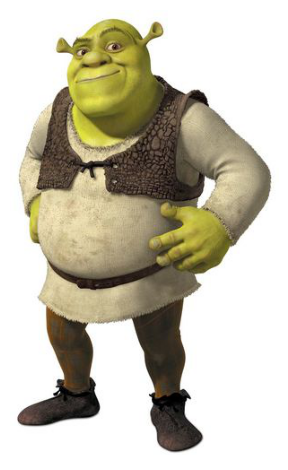

In [30]:
image = read_image(IMAGE_NAME)
height, width = image.shape[:2]

show_image(image)

Картинка в памяти хранится как трехмерный массив `[h; w; 3]`, однако алгоритмы кластеризации требуют от нас двумерный массив `[n_samples; n_features]`. В случае картинок, `n_features` — 3, RGB код цвета каждого пикселя, а `n_samples` общее число пикселей.

In [31]:
def preprocess_image(image: np.ndarray) -> np.ndarray:
    """Функция для препроцессинга картинки

    Parameters
    ----------
    image: исходная картинка
        массив размером [h; w; 3]

    Return
    ------
        матрица размером [n_pixels; 3]
    """
    h, w, _ = image.shape
    image_flat = image.reshape(h*w, 3)
    
    return image_flat

In [32]:
X_train = preprocess_image(image)

assert X_train.shape == (height * width, 3)

В качестве первого алгоритма возьмем [`KMeans`](https://scikit-learn.org/stable/modules/clustering.html#k-means). Его идея близка к алгоритму классификации "K ближайших соседей", считаются попарные расстояния между точками и наиболее близкие объединяются в кластеры

In [33]:
k_means = KMeans(n_clusters=5, n_init=1, random_state=RANDOM_SEED)
k_means.fit(X_train)

KMeans(n_clusters=5, n_init=1, random_state=12648430)

Заменим каждый цвет на картинке на средний цвет кластера, куда попал соответствующий кластер.

Для этого реализуйте функцию `replace_to_centroid`, которая принимает полученные индексы кластеров и цвета кластеров и возвращает цвета для каждой точки.

In [34]:
def replace_to_centroid(
    predicted_cluster: np.ndarray, centroids: np.ndarray
) -> np.ndarray:
    """Функция для получения центроиды кластера по ее индексу

    Parameters
    ----------
    predicted_cluster: предсказанные кластеры
        массив размером [n_samples]
        каждое значение от 0 до n_clusters
    centroids: центры кластеров
        массив размером [n_clusters; 3]

    Return
    ------
        матрица размером [n_samples; 3]
    """
    n_samples = len(predicted_cluster)
    centroid_matrix = np.zeros((n_samples, 3))
    for i in range(n_samples):
        centroid_matrix[i] = centroids[predicted_cluster[i]]

    return centroid_matrix

In [35]:
predicted_clusters = k_means.predict(X_train)
X_predicted = replace_to_centroid(predicted_clusters, k_means.cluster_centers_)

assert X_predicted.shape == X_train.shape

Приведем матрицу обратно к формату картинки и посмотрим, что получилось!

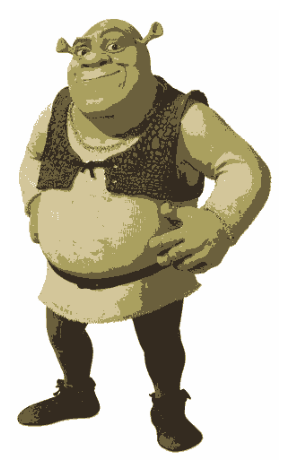

In [36]:
new_image = X_predicted.reshape(height, width, 3).astype(np.int32)
show_image(new_image)